In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SpikeInterface pipeline for Mease Lab - Syntalos

In [2]:
import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
from datetime import datetime
%matplotlib notebook

In [4]:
from mease_lab_to_nwb import SyntalosRecordingExtractor
from nwb_conversion_tools.conversion_tools import save_si_object

In [12]:
stub_test = True
nsec_stub = 10

## 1) Load Intan recordings, compute LFP, and inspect signals

In [5]:
syntalos_folder = Path('/Users/abuccino/Documents/Data/catalyst/heidelberg/syntalos/Latest_Syntalos_Recording_20200730/')

In [6]:
recording = SyntalosRecordingExtractor(syntalos_folder)

/Users/abuccino/Documents/Codes/ephys/pyintan/pyintan/tools.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  states = np.array(states)


### Compute LFP

In [7]:
freq_min_lfp = 1
freq_max_lfp = 300
freq_resample_lfp = 1000.

In [8]:
recording_lfp = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_lfp, freq_max=freq_max_lfp)
recording_lfp = st.preprocessing.resample(recording_lfp, freq_resample_lfp)

In [9]:
print(f"Sampling frequency AP: {recording.get_sampling_frequency()}")
print(f"Sampling frequency LF: {recording_lfp.get_sampling_frequency()}")      

Sampling frequency AP: 30000.0
Sampling frequency LF: 1000.0


### Inspect signals

<IPython.core.display.Javascript object>


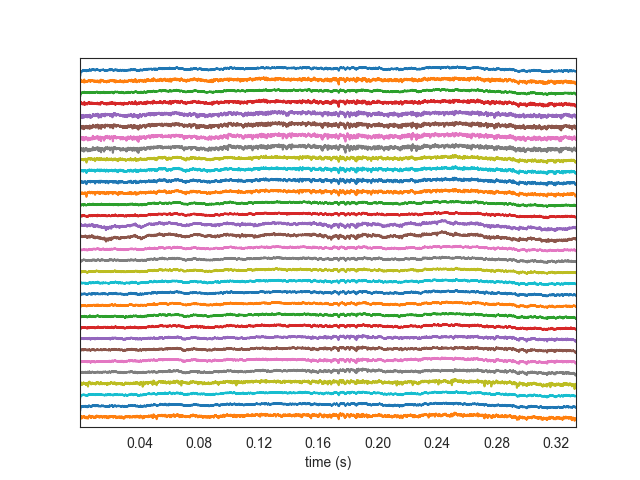

In [10]:
w_ts_ap = sw.plot_timeseries(recording)

<IPython.core.display.Javascript object>


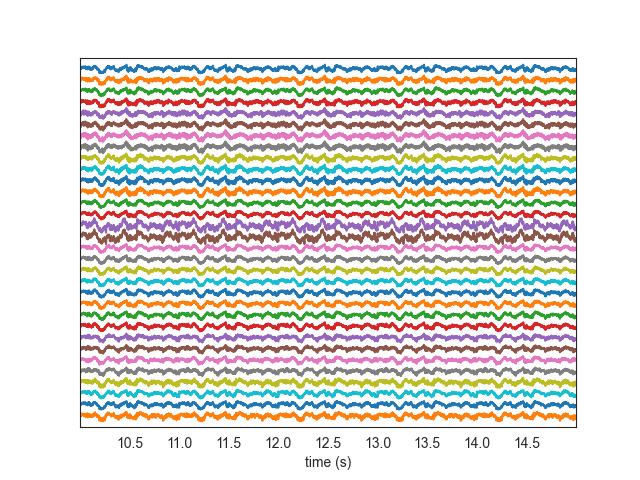

In [13]:
w_ts_lf = sw.plot_timeseries(recording_lfp, trange=[10, 15])

## 2) Pre-processing

In [14]:
apply_filter = True
apply_cmr = True
freq_min_hp = 300
freq_max_hp = 3000

In [15]:
if apply_filter:
    recording_processed = st.preprocessing.bandpass_filter(recording, freq_min=freq_min_hp, freq_max=freq_max_hp)
else:
    recording_processed = recording
if apply_cmr:
    recording_processed = st.preprocessing.common_reference(recording)
else:
    recording_processed = recording

In [17]:
if stub_test:
    recoridng_processed = se.SubRecordingExtractor(recording_processed, 
                                                   end_frame=int(30*recording_processed.get_sampling_frequency()))

In [18]:
num_frames = recording_processed.get_num_frames()

<IPython.core.display.Javascript object>


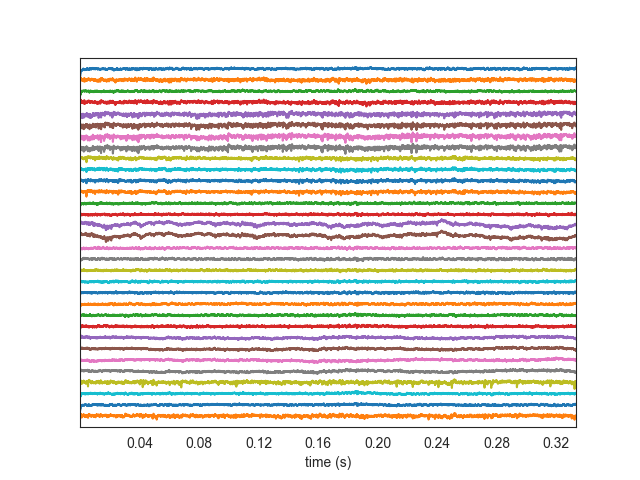

In [19]:
w_ts_ap = sw.plot_timeseries(recording_processed)

## 3) Run spike sorters

In [31]:
sorter_list = ['ironclust']

In [32]:
# Inspect sorter-specific parameters and defaults
for sorter in sorter_list:
    print(f"{sorter} params description:")
    pprint(ss.get_params_description(sorter))
    print("Default params:")
    pprint(ss.get_default_params(sorter))    

ironclust params description:
{'adjacency_radius': 'Use -1 to include all channels in every neighborhood',
 'adjacency_radius_out': 'Use -1 to include all channels in every neighborhood',
 'batch_sec_drift': 'Batch duration in seconds. clustering time duration',
 'clip_post': 'Post-peak clip duration in ms',
 'clip_pre': 'Pre-peak clip duration in ms',
 'common_ref_type': 'Common reference type: none, mean, median, trimmean',
 'delta_cut': 'Cluster detection threshold (delta-cutoff)',
 'detect_sign': 'Use -1 (negative), 1 (positive) or 0 (both) depending on the '
                'sign of the spikes in the recording',
 'detect_threshold': 'detection threshold',
 'fGpu': 'Use GPU if True',
 'fParfor': 'Parfor loop',
 'feature_type': 'gpca, pca, vpp, vmin, vminmax, cov, energy, xcov',
 'fft_thresh': 'FFT-based noise peak threshold',
 'fft_thresh_low': 'FFT-based noise peak lower threshold (set to 0 to disable '
                   'dual thresholding scheme)',
 'filter': 'Enable or disable 

In [33]:
# user-specific parameters
sorter_params = dict(ironclust=dict(),
                     tridesclous=dict())

In [35]:
sorting_outputs = ss.run_sorters(sorter_list=sorter_list, 
                                 working_folder='syntalos_si_output',
                                 recording_dict_or_list=dict(rec0=recording_processed), 
                                 sorter_params=sorter_params, verbose=True)

Num. channels = 32, Num. timepoints = 28703040, duration = 15.946133333333334 minutes
Creating argfile.txt...
Running ironclust in /Users/abuccino/Documents/Codes/catalyst/lab_conversions/mease-lab-to-nwb/notebooks/syntalos_si_output/rec0/ironclust/tmp...
RUNNING SHELL SCRIPT: /Users/abuccino/Documents/Codes/catalyst/lab_conversions/mease-lab-to-nwb/notebooks/syntalos_si_output/rec0/ironclust/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019





                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.mathw

ironclust run time 344.31s


## 4) Post-processing: extract waveforms, templates, quality metrics, extracellular features

### Set postprocessing parameters

In [ ]:
# Post-processing params
postprocessing_params = st.postprocessing.get_common_params()
pprint(postprocessing_params)

In [ ]:
# (optional) change parameters
postprocessing_params['max_spikes_per_unit'] = 1000  # with None, all waveforms are extracted

### Set quality metric list

In [ ]:
# Quality metrics
qc_list = st.validation.get_quality_metrics_list()
print(f"Available quality metrics: {qc_list}")

In [ ]:
# (optional) define subset of qc
qc_list = ['snr', 'isi_violation', 'firing_rate']

### Set extracellular features

In [ ]:
# Extracellular features
ec_list = st.postprocessing.get_template_features_list()
print(f"Available EC features: {ec_list}")

In [ ]:
# (optional) define subset of ec
ec_list = ['peak_to_valley', 'halfwidth']

### Postprocess all sorting outputs

In [ ]:
st.validation.compute_quality_metrics?

In [ ]:
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    tmp_folder = spikeinterface_folder / 'tmp' / sorter
    tmp_folder.mkdir(parents=True)
    
    # set local tmp folder
    sorting.set_tmp_folder(tmp_folder)
    
    # compute waveforms
    waveforms = st.postprocessing.get_unit_waveforms(recording_processed, sorting, **postprocessing_params)
    
    # compute templates
    templates = st.postprocessing.get_unit_templates(recording_processed, sorting, **postprocessing_params)
    
    # comput EC features
    ec = st.postprocessing.compute_unit_template_features(recording_processed, sorting,
                                                          feature_names=ec_list, as_dataframe=True)
    # compute QCs
    qc = st.validation.compute_quality_metrics(sorting, recording=recording_processed, 
                                               metric_names=qc_list, as_dataframe=True)
    
    # export to phy
    phy_folder = spikeinterface_folder / 'phy' / sorter
    st.postprocessing.export_to_phy(recording_processed, sorting, phy_folder)

## 5) Ensamble spike sorting

If len(sorter_list) > 1

In [ ]:
# retrieve sortings and sorter names
sorting_list = []
sorter_names_comp = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorting_list.append(sorting)
    sorter_names_comp.append(sorter)

In [ ]:
# run multisorting comparison
mcmp = sc.compare_multiple_sorters(sorting_list=sorting_list, name_list=sorter_names)

In [ ]:
# plot agreement results
w_agr = sw.plot_multicomp_agreement(mcmp)

In [ ]:
# extract ensamble sorting
sorting_ensamble = mcmp.get_agreement_sorting(minimum_agreement_count=2)

# 6) Automatic curation

In [ ]:
# define curators and thresholds
isi_violation_threshold = 0.5
snr_threshold = 5
firing_rate_threshold = 0.1

In [ ]:
sorting_auto_curated = []
sorter_names_curation = []
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    sorter_names_curation.append(sorter)
    
    # firing rate threshold
    sorting_curated = st.curation.threshold_firing_rates(sorting, duration_in_frames=num_frames,
                                                         threshold=firing_rate_threshold, 
                                                         threshold_sign='less')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_isi_violations(sorting, duration_in_frames=num_frames,
                                                           threshold=isi_violation_threshold, 
                                                           threshold_sign='greater')
    
    # isi violation threshold
    sorting_curated = st.curation.threshold_snrs(sorting, recording=recording_processed,
                                                 threshold=snr_threshold, 
                                                 threshold_sign='less')
    sorting_auto_curated.append(sorting_curated)

## 7) Save all outputs in spikeinterface folder

In [ ]:
cache_raw = False
cache_processed = False
cache_lfp = False
cache_sortings = True
cache_curated = True
cache_comparison = True

In [ ]:
cache_folder = spikeinterface_folder / 'cache'
cache_folder.mkdir(parents=True, exist_ok=True)

### Dump recordings

In [ ]:
if cache_raw:
    recording_raw_cache = se.CacheRecordingExtractor(recording_ap_sync, 
                                                     save_path=cache_folder / 'raw.dat')
else:
    recording_raw_cache = recording_ap_sync
recording_raw_cache.dump_to_pickle(cache_folder / 'raw.pkl')

if cache_raw:
    recording_lfp_cache = se.CacheRecordingExtractor(recording_lf_sync, 
                                                     save_path=cache_folder / 'lfp.dat')
else:
    recording_lfp_cache = recording_lf_sync
recording_lfp_cache.dump_to_pickle(cache_folder / 'lfp.pkl')

if cache_processed:
    recording_processed_cache = se.CacheRecordingExtractor(recording_processed, 
                                                           save_path=cache_folder / 'processed.dat')
else:
    recording_processed_cache = recording_processed
recording_processed_cache.dump_to_pickle(cache_folder / 'raw.pkl')

### Dump sortings

In [ ]:
# Sorter output
for result_name, sorting in sorting_outputs.items():
    rec_name, sorter = result_name
    if cache_sortings:
        sorting_cache = se.CacheSortingExtractor(sorting, cache_folder / f'sorting_{sorter}.npz')
    else:
        sorting_cache = sorting
    sorting_cache.dump_to_pickle(cache_folder / f'sorting_{sorter}.pkl', include_features=False)

# Curated output
for (sorter, sorting_curated) in zip(sorter_names_curation, sorting_auto_curated):
    if cache_curated:
        sorting_auto_cache = se.CacheSortingExtractor(sorting_curated, cache_folder / f'sorting_{sorter}_auto.npz')
    else:
        sorting_auto_cache = sorting_curated
    sorting_auto_cache.dump_to_pickle(cache_folder / f'sorting_{sorter}_auto.pkl', include_features=False)
    
# Ensamble output
if cache_comparison:
    sorting_ensamble_cache = se.CacheSortingExtractor(sorting, cache_folder / f'sorting_ensamble.npz')
else:
    sorting_ensamble_cache = sorting_ensamble
sorting_ensamble_cache.dump_to_pickle(cache_folder / f'sorting_ensamble.pkl', include_features=False)

## Export to phy

note to myself (add the possibility to save specific user defined properties)

In [ ]:
st.postprocessing.export_to_phy